In [4]:
import os, time, math, textwrap, pathlib
import numpy as np
import matplotlib.pyplot as plt
OUT_DIR = '/mnt/data'
import os; os.makedirs(OUT_DIR, exist_ok=True)
import pandas as pd
from scipy.optimize import minimize

In [5]:
def ackley(xy):
    import math
    x, y = xy
    a = -20.0 * math.exp(-0.2 * math.sqrt(0.5*(x*x + y*y)))
    b = -math.exp(0.5*(math.cos(2*math.pi*x) + math.cos(2*math.pi*y)))
    return a + b + math.e + 20.0

def branin(xy):
    import math
    x, y = xy
    return (y - (5.1/(4*math.pi**2))*x*x + (5/math.pi)*x - 6)**2 + 10*(1 - 1/(8*math.pi))*math.cos(x) + 10

def rosenbrock(xy):
    x, y = xy
    return (1 - x)**2 + 5*(y - x*x)**2

In [6]:
def make_counted(f):
    state={'evals':0}
    def g(x):
        state['evals']+=1
        return f(x)
    return g, state

def line_search_golden(f, x, d, a: float = -50, b: float = 50, tol: float = 1e-6):
    golden_ratio = (np.sqrt(5) - 1) / 2  # ≈ 0.618
    nrm = np.linalg.norm(d)
    if nrm == 0:
        return x.copy(), 0.0, 0
    d = d / nrm

    # One-dimensional function along direction d
    def phi(alpha):
        return f(x + alpha * d)

    # Initialize two interior points
    alpha1 = a + (1 - golden_ratio) * (b - a)
    alpha2 = a + golden_ratio * (b - a)
    f1 = phi(alpha1)
    f2 = phi(alpha2)

    it = 0
    while abs(b - a) > tol:
        if f1 < f2:
            b = alpha2
            alpha2 = alpha1
            f2 = f1
            alpha1 = a + (1 - golden_ratio) * (b - a)
            f1 = phi(alpha1)
        else:
            a = alpha1
            alpha1 = alpha2
            f1 = f2
            alpha2 = a + golden_ratio * (b - a)
            f2 = phi(alpha2)
        it += 1

    alpha_opt = (a + b) / 2
    return x + alpha_opt * d, alpha_opt, (it + 1)


In [7]:
def powell(f, x0, tol=1e-6, max_outer=10000):
    f_counted, st = make_counted(f)
    x = x0.astype(float).copy()
    n = len(x)
    U = [np.eye(n)[i].copy() for i in range(n)]
    delta = float('inf'); outer = 0
    traj = [x.copy()]; history_f=[f_counted(x)]
    t0=time.time()
    while delta > tol and outer < max_outer:
        x_prev = x.copy()
        for i in range(n):
            x, _a, _ = line_search_golden(f_counted, x, U[i])
            traj.append(x.copy()); history_f.append(f_counted(x))
        for i in range(n-1):
            U[i] = U[i+1]
        U[n-1] = x - x_prev
        x, _a, _ = line_search_golden(f_counted, x, U[n-1])
        traj.append(x.copy()); history_f.append(f_counted(x))
        delta = np.linalg.norm(x - x_prev)
        outer += 1
    t = time.time()-t0
    return x, f(x), np.array(traj), outer, st['evals'], t, np.array(history_f)

def ccd_accel(f, x0, tol=1e-6, max_outer=10000):
    f_counted, st = make_counted(f)
    x = x0.copy(); n=len(x)
    outer=0
    traj=[x.copy()]; history_f=[f_counted(x)]
    t0=time.time()
    for outer in range(max_outer):
        x_prev=x.copy()
        for i in range(n):
            e=np.zeros_like(x); e[i]=1.0
            x,_=line_search_golden(f_counted, x, e)
            traj.append(x.copy()); history_f.append(f_counted(x))
        d_acc=x - x_prev
        x,_=line_search_golden(f_counted, x, d_acc)
        traj.append(x.copy()); history_f.append(f_counted(x))
        if np.linalg.norm(x - x_prev) < tol:
            break
    t=time.time()-t0
    return x, f(x), np.array(traj), outer, st['evals'], t, np.array(history_f)


In [8]:
def make_grid_and_Z(func, name):
    if name.lower().startswith('ackley'):
        xr = np.linspace(-4,2,400); yr = np.linspace(-4,1,400)
    elif name.lower().startswith('branin'):
        xr = np.linspace(0,10,450); yr = np.linspace(1,3,450)
    elif name.lower().startswith('rosenbrock'):
        xr = np.linspace(-2,2,400); yr = np.linspace(-1,3,400)
    else:
        xr = np.linspace(-3,3,400); yr = np.linspace(-3,3,400)
    X,Y = np.meshgrid(xr, yr)
    Z = np.array([func(np.array([xi, yi])) for xi, yi in zip(X.ravel(), Y.ravel())]).reshape(X.shape)
    return X,Y,Z

def plot_powell_trajectory(func, name, traj, known_min=None, filename=None):
    X,Y,Z = make_grid_and_Z(func, name)
    plt.figure(figsize=(7,6))
    plt.contour(X,Y,Z,levels=50)
    plt.plot(traj[:,0], traj[:,1], marker='o', color='darkred', linewidth=1, markersize=2, alpha=0.9, label='Powell path')
    plt.plot(traj[0,0], traj[0,1], marker='o', color='orange', markersize=8, label='Start')
    plt.plot(traj[-1,0], traj[-1,1], marker='o', color='green', markersize=8, label='End')
    if known_min is not None:
        km=np.array(known_min)
        plt.plot(km[0], km[1], marker='*', markersize=10, label='Known global min')
    plt.xlabel('x'); plt.ylabel('y'); plt.title(f'Powell Trajectory — {name}')
    plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout()
    if filename:
        plt.savefig(os.path.join(OUT_DIR, filename), dpi=150)
    plt.show()

def plot_convergence(history_f, name, filename=None):
    import matplotlib.pyplot as plt, os
    plt.figure(figsize=(7,5))
    plt.plot(range(len(history_f)), history_f, marker='o', linewidth=1)
    plt.xlabel('Iteration (sweeps & steps)'); plt.ylabel('Objective f(x)')
    plt.title(f'Convergence — {name}')
    plt.grid(True, alpha=0.3); plt.tight_layout()
    if filename:
        plt.savefig(os.path.join(OUT_DIR, filename), dpi=150)
    plt.show()

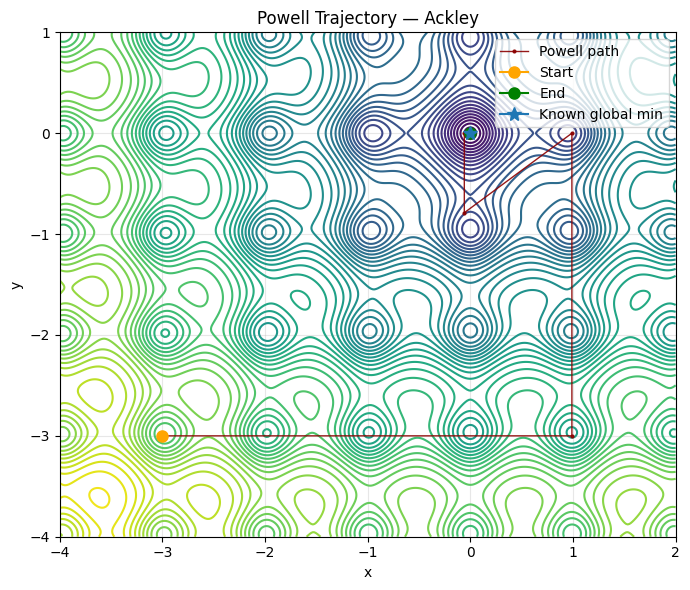

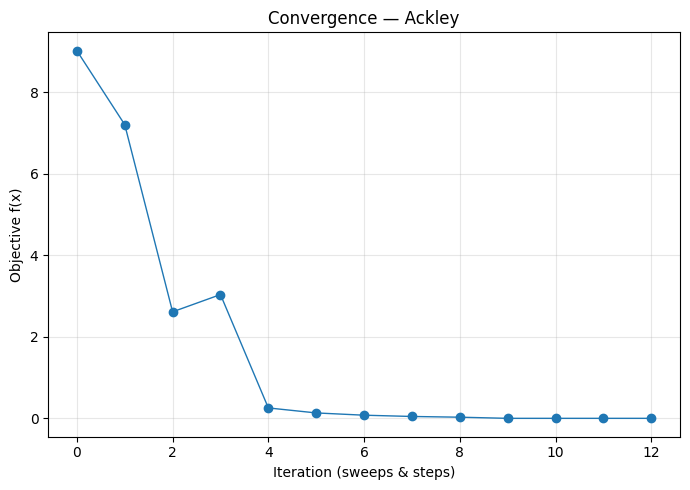

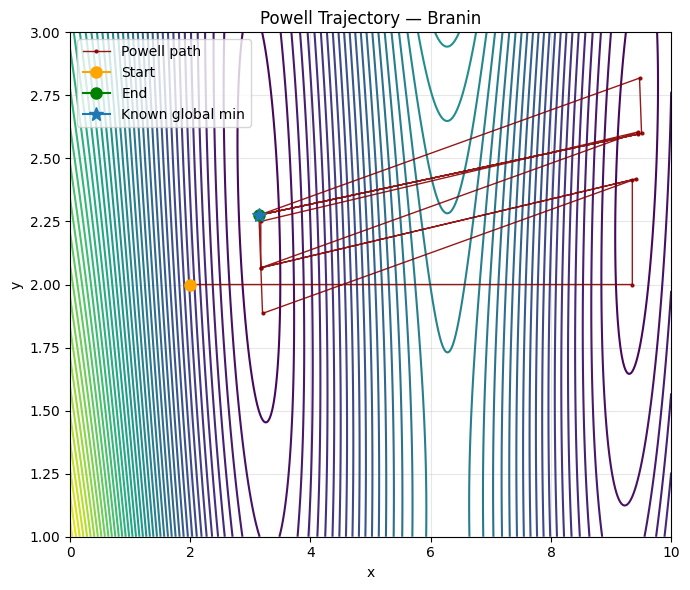

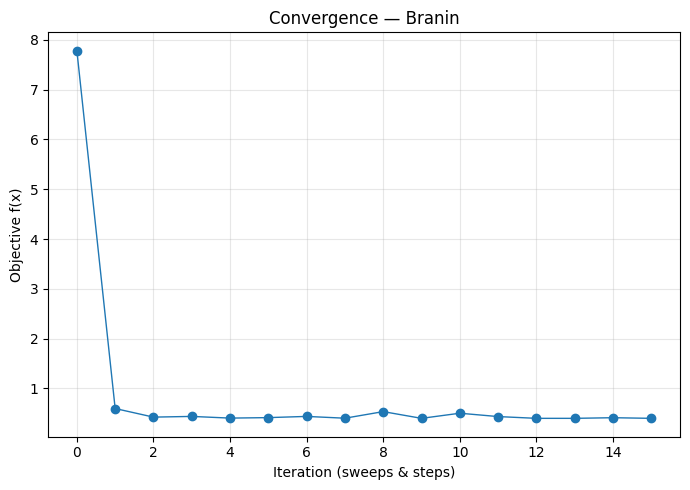

  Function         Start  Method  \
0   Ackley  [-3.0, -3.0]  Powell   
1   Branin    [2.0, 2.0]  Powell   

                                           x_found    f(x_found)  Iterations  \
0  [1.8209448529801457e-07, 2.087538407595914e-08]  5.184153e-07           4   
1          [3.141591625794274, 2.2750062028144464]  3.978874e-01           5   

   FuncEvals   Time(s)  
0        505  0.007946  
1        631  0.016023  


In [9]:
# Example runs (user can re-run)
import math, numpy as np, pandas as pd
records=[]
xa0=np.array([-3.,-3.])
xa, fa, tra, ita, eva, ta, ha = powell(ackley, xa0)
plot_powell_trajectory(ackley, 'Ackley', tra, known_min=(0.,0.))
plot_convergence(ha, 'Ackley')
records.append(['Ackley', xa0.tolist(), 'Powell', xa.tolist(), fa, ita, eva, ta])

xb0=np.array([2.,2.])
xb, fb, trb, itb, evb, tb, hb = powell(branin, xb0)
plot_powell_trajectory(branin, 'Branin', trb, known_min=(math.pi, 2.275))
plot_convergence(hb, 'Branin')
records.append(['Branin', xb0.tolist(), 'Powell', xb.tolist(), fb, itb, evb, tb])



df=pd.DataFrame(records, columns=['Function','Start','Method','x_found','f(x_found)','Iterations','FuncEvals','Time(s)'])
print(df)

In [10]:
tests = [
    (rosenbrock, 'Rosenbrock', np.array([-1.5,  2.0])),
    (rosenbrock, 'Rosenbrock', np.array([ 4.0,  1.0])),
    (ackley,    'Ackley',    np.array([-1.5,  2.0])),
    (ackley,    'Ackley',    np.array([ 4.0,  1.0])),
]

methods = [
    ('Powell', powell),
    ('CCD-accel', ccd_accel),
]

records = []
for func, name, x0 in tests:
    for mname, mfunc in methods:
        x_found, fx, _traj, iterations, _fevals, t_used, _hist = mfunc(func, x0)
        records.append([
            name,
            x0.tolist(),
            mname,
            x_found.tolist(),
            float(fx),
            int(iterations),
            float(t_used)
        ])

df = pd.DataFrame(records, columns=['function', 'start', 'method', 'x found', 'f(x found)', 'iterations', 'time of working'])
print(df.to_string(index=False))


ValueError: too many values to unpack (expected 2)

In [ ]:
# 新单元格：line-search 对比（golden-section vs backtracking）
import numpy as np, time, pandas as pd

def line_search_backtracking(f, x, d, alpha0=1.0, rho=0.5, c=1e-4, tol=1e-8, max_iter=1000):
    nrm = np.linalg.norm(d)
    if nrm == 0:
        return x.copy(), 0.0, 0
    d_unit = d / nrm
    def phi(a):
        return f(x + a * d_unit)
    phi0 = phi(0.0)
    # 数值近似方向导数（小步长）
    eps = 1e-8
    dphi0 = (phi(eps) - phi0) / eps
    alpha = alpha0
    it = 0
    while it < max_iter:
        val = phi(alpha)
        if val <= phi0 + c * alpha * dphi0:
            break
        alpha *= rho
        it += 1
    return x + alpha * d_unit, alpha, (it + 1)

def powell_with_ls(f, x0, line_search_func=line_search_golden, tol=1e-6, max_outer=10000):
    f_counted, st = make_counted(f)
    x = x0.astype(float).copy()
    n = len(x)
    U = [np.eye(n)[i].copy() for i in range(n)]
    delta = float('inf'); outer = 0
    traj = [x.copy()]; history_f = [f_counted(x)]
    t0 = time.time()
    while delta > tol and outer < max_outer:
        x_prev = x.copy()
        for i in range(n):
            x, _a, _ = line_search_func(f_counted, x, U[i])
            traj.append(x.copy()); history_f.append(f_counted(x))
        for i in range(n-1):
            U[i] = U[i+1]
        U[n-1] = x - x_prev
        x, _a, _ = line_search_func(f_counted, x, U[n-1])
        traj.append(x.copy()); history_f.append(f_counted(x))
        delta = np.linalg.norm(x - x_prev)
        outer += 1
    t = time.time() - t0
    return x, f(x), np.array(traj), outer, st['evals'], t, np.array(history_f)

def ccd_with_ls(f, x0, line_search_func=line_search_golden, tol=1e-6, max_outer=10000):
    f_counted, st = make_counted(f)
    x = x0.astype(float).copy(); n = len(x)
    delta = float('inf'); outer = 0
    traj = [x.copy()]; history_f = [f_counted(x)]
    t0 = time.time()
    while delta > tol and outer < max_outer:
        x_prev = x.copy()
        for i in range(n):
            e = np.zeros_like(x); e[i] = 1.0
            x, _a, _ = line_search_func(f_counted, x, e)
            traj.append(x.copy()); history_f.append(f_counted(x))
        d_acc = x - x_prev
        x, _a, _ = line_search_func(f_counted, x, d_acc)
        traj.append(x.copy()); history_f.append(f_counted(x))
        delta = np.linalg.norm(x - x_prev); outer += 1
    t = time.time() - t0
    return x, f(x), np.array(traj), outer, st['evals'], t, np.array(history_f)

# 测试集合：两个函数 × 两个起点（共 4 起点）
tests = [
    (rosenbrock, 'Rosenbrock', np.array([-1.5, 2.0])),
    (rosenbrock, 'Rosenbrock', np.array([4.0, 1.0])),
    (ackley, 'Ackley', np.array([-1.5, 2.0])),
    (ackley, 'Ackley', np.array([4.0, 1.0])),
]

methods = [
    ('Powell', powell_with_ls),
    ('CCD-accel', ccd_with_ls),
]

line_searches = [
    ('golden', line_search_golden),
    ('backtracking', line_search_backtracking),
]

records = []
for func, fname, x0 in tests:
    for mname, mfunc in methods:
        for ls_name, ls_func in line_searches:
            x_found, fx, _traj, iterations, fevals, t_used, _hist = mfunc(func, x0, line_search_func=ls_func)
            records.append([
                fname,
                x0.tolist(),
                mname,
                ls_name,
                x_found.tolist(),
                float(fx),
                int(iterations),
                int(fevals),
                float(t_used)
            ])

df = pd.DataFrame(records, columns=[
    'function','start','method','line_search','x found','f(x found)','iterations','FuncEvals','time of working'
])
print(df.to_string(index=False))

  function       start    method  line_search                                           x found   f(x found)  iterations  FuncEvals  time of working
Rosenbrock [-1.5, 2.0]    Powell       golden          [1.0000000259803261, 1.0000000668505686] 1.783525e-15          27       3403         0.032770
Rosenbrock [-1.5, 2.0]    Powell backtracking                                      [-1.25, 2.0] 6.019531e+00           2        234         0.000510
Rosenbrock [-1.5, 2.0] CCD-accel       golden         [-1.3504798182250357, 1.9985184618106369] 5.677396e+00           3        379         0.004040
Rosenbrock [-1.5, 2.0] CCD-accel backtracking                                      [-1.25, 2.0] 6.019531e+00           2        234         0.002905
Rosenbrock  [4.0, 1.0]    Powell       golden          [1.0000000059818903, 0.9999999999999912] 7.514443e-16           2        253         0.002013
Rosenbrock  [4.0, 1.0]    Powell backtracking                          [4.0, 16.00000001330045] 9.000000e+